# Incident Detection Using Graph Neural Networks

This notebook demonstrates incident detection using the SpatioDevNet model on labeled topology data. The process involves:

1. **Data Loading**: Load preprocessed training and test cases
2. **Data Preparation**: Convert data to PyTorch Geometric format
3. **Model Training**: Train the SpatioDevNet model for incident classification
4. **Evaluation**: Assess model performance using various metrics

**Model Architecture**: SpatioDevNet combines graph neural networks with attention pooling to classify network topologies as incidents or normal operations.

## Step 1: Import Required Libraries

Import essential libraries for deep learning, graph processing, and model evaluation.

In [1]:
# Data processing and serialization
import pickle
import pandas as pd
import numpy as np

# PyTorch and PyTorch Geometric for deep learning
import torch
from torch_geometric.data import Data

# Model evaluation metrics
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# Custom model implementation
import sys
sys.path.append('../src')
from incident_detection import callSpatioDevNet

/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load Training Data

Load the preprocessed training cases that contain labeled topology data for model training.

In [2]:
# Load training cases with labeled topologies
# Each case contains node features, edge information, and incident labels
with open('../data/train_cases.pkl', 'rb') as f:
    train_cases = pickle.load(f)

## Step 3: Load Test Data

Load the test cases for model evaluation and performance assessment.

In [3]:
# Load test cases for model evaluation
# These cases are used to assess model performance on unseen data
with open('../data/test_cases.pkl', 'rb') as f:
    test_cases = pickle.load(f)

## Step 4: Convert Training Data to PyTorch Geometric Format

Transform training data into PyTorch Geometric Data objects with:
- **Node features (x)**: Service-level metrics and characteristics
- **Edge indices**: Bidirectional connections between services
- **Edge attributes**: Relationship features between services
- **Global features**: System-wide characteristics
- **Labels (y)**: Binary incident classification (1=incident, 0=normal)

In [4]:
# Convert training cases to PyTorch Geometric Data format
# Each Data object represents a topology with all necessary features for GNN processing
trainlist = [Data(x=torch.tensor(item['x'], dtype=torch.float), 
            edge_index=torch.tensor(item['bi_edge_index'], dtype=torch.long).t().contiguous(),
            y=torch.tensor([[1 if item['y'] == 1 else 0]], dtype = torch.float),
            edge_attr=torch.tensor(item['bi_edge_fea'], dtype = torch.float),
            global_x = torch.tensor(item['global_fea'], dtype = torch.float).unsqueeze(0)) for item in train_cases]

## Step 5: Convert Test Data to PyTorch Geometric Format

Apply the same data transformation to test cases for consistent model input format.

In [5]:
# Convert test cases to PyTorch Geometric Data format
# Maintains the same structure as training data for consistent evaluation
testlist = [Data(x=torch.tensor(item['x'], dtype=torch.float), 
            edge_index=torch.tensor(item['bi_edge_index'], dtype=torch.long).t().contiguous(),
            y=torch.tensor([[1 if item['y'] == 1 else 0]], dtype = torch.float),
            edge_attr=torch.tensor(item['bi_edge_fea'], dtype = torch.float),
            global_x = torch.tensor(item['global_fea'], dtype = torch.float).unsqueeze(0)) for item in test_cases]

## Step 6: Extract Training Labels

Extract binary labels from training data for evaluation metrics calculation.

In [6]:
# Extract training labels for metric calculation
# Convert tensor labels to integer format for sklearn metrics
train_labels = [int(item.y) for item in trainlist]

## Step 7: Extract Test Labels

Extract binary labels from test data for model performance evaluation.

In [7]:
# Extract test labels for evaluation
# These will be used to assess model performance on unseen data
test_labels = [int(item.y) for item in testlist]

## Step 8: Analyze Training Data Distribution

Examine the class distribution in training data to understand dataset balance.

In [8]:
# Analyze training data class distribution
# Important for understanding dataset balance and potential bias
pd.Series(train_labels).value_counts()

0    2749
1     311
Name: count, dtype: int64

## Step 9: Analyze Test Data Distribution

Examine the class distribution in test data to ensure representative evaluation.

In [9]:
# Analyze test data class distribution
# Ensures test set is representative of the problem domain
pd.Series(test_labels).value_counts()

0    2745
1     315
Name: count, dtype: int64

## Step 10: Inspect Sample Data Structure

Examine the structure of a sample training instance to verify data format.

In [10]:
# Inspect the structure of the first training sample
# Verify data format and dimensions for model compatibility
trainlist[0]

Data(x=[2, 14], edge_index=[2, 2], edge_attr=[2, 7], y=[1, 1], global_x=[1, 4])

## Step 11: Define Model Hyperparameters

Set up model architecture parameters based on data dimensions:
- **INPUT_DIM**: Number of node features per service
- **HIDDEN_DIM**: Hidden layer size for graph neural network
- **EDGE_ATTR_LEN**: Number of edge features between services
- **GLOBAL_FEA_LEN**: Number of global topology features

In [11]:
# Define model hyperparameters based on data dimensions
# These parameters determine the model architecture
INPUT_DIM = trainlist[0].x.shape[1]        # Node feature dimension
HIDDEN_DIM = 20                            # Hidden layer size
EDGE_ATTR_LEN = trainlist[0].edge_attr.shape[1]  # Edge feature dimension
GLOBAL_FEA_LEN = trainlist[0].global_x.shape[1]  # Global feature dimension

## Step 12: Configure PyTorch Threading

Set PyTorch to use single thread for reproducible results and avoid threading conflicts.

In [12]:
# Set PyTorch to use single thread for reproducibility
# Prevents threading-related randomness in model training
torch.set_num_threads(1)

# Stage 1 Demo: Cold Start Evaluation

This stage evaluates the model's performance without training (cold start scenario). The model uses pre-trained weights to make predictions on the training data to establish baseline performance.

## Step 13: Cold Start Model Evaluation

Evaluate model performance across multiple random seeds without training:
- Initialize model with different random seeds for robustness
- Use pre-trained weights (FinalModel_OnlineBoutique.pt)
- Evaluate on training data to establish baseline
- Calculate precision, recall, F1-score, and average precision

In [13]:
# Initialize lists to store evaluation metrics across multiple runs
gied_ap = []   # Average Precision scores
gied_prf = []  # Precision, Recall, F1-score tuples

# Run evaluation with 5 different random seeds for statistical robustness
for seedi in range(5):
    # Model configuration parameters
    NAME = 'FinalModel_OnlineBoutique'  # Pre-trained model name
    LOSS = 'cross_entropy'              # Loss function for binary classification
    POOLING = 'attention'               # Graph pooling method
    
    # Initialize SpatioDevNet model with specified parameters
    model = callSpatioDevNet(name = NAME, input_dim = INPUT_DIM, hidden_dim = HIDDEN_DIM, 
                           edge_attr_len = EDGE_ATTR_LEN, global_fea_len = GLOBAL_FEA_LEN, 
                           num_epochs = 60, nonlinear_scorer = False, act = False, 
                           pooling = POOLING, loss_func = LOSS, lr = 1e-3, seed = seedi)
    
    # Cold start prediction using pre-trained weights
    # Returns predictions, probabilities, and learned features
    preds, preds_proba, feas = model.cold_start_predict(trainlist)
    
    # Calculate evaluation metrics
    gied_prf.append(precision_recall_fscore_support(train_labels, preds, average = 'binary'))
    gied_ap.append(average_precision_score(train_labels, preds_proba))

/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 96/96 [00:00<00:00, 398.50it/s]
/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 96/96 [00:00<00:00, 397.50it/s]
/home/user/anaconda3/envs/pilot/lib/python3.8/site-packages/torch_geometric/deprecat

## Step 14: Display Cold Start Precision, Recall, F1-Score Results

Show the detailed performance metrics from cold start evaluation.

In [14]:
# Display precision, recall, F1-score results for all seed runs
# Each tuple contains (precision, recall, f1_score, support)
print(gied_prf)

[(0.9123376623376623, 0.9035369774919614, 0.9079159935379645, None), (0.9096774193548387, 0.9067524115755627, 0.9082125603864735, None), (0.939799331103679, 0.9035369774919614, 0.921311475409836, None), (0.9235880398671097, 0.8938906752411575, 0.9084967320261438, None), (0.9344827586206896, 0.8713826366559485, 0.9018302828618968, None)]


## Step 15: Display Cold Start Average Precision Results

Show the average precision scores from cold start evaluation across all runs.

In [15]:
# Display average precision scores for all seed runs
# Average precision summarizes precision-recall curve performance
print(gied_ap)

[0.9094923306811694, 0.927512869425138, 0.9210954357224375, 0.9267385234915312, 0.9248027880636236]


# Stage 2 Demo: Full Training and Evaluation

This stage demonstrates the complete training and evaluation pipeline with optimal threshold selection.

## Step 16: Define Threshold Optimization Function

Implement a function to find the optimal classification threshold that maximizes F1-score on the training set.

In [16]:
def bf_search(labels, scores):
    """
    Find the optimal threshold using the training set to maximize F1-score
    
    Args:
        labels: True binary labels
        scores: Predicted probability scores
    
    Returns:
        tuple: Best (precision, recall, f1_score, support) metrics
        float: Optimal threshold value
    """
    m = (-1., -1., -1., None)  # Initialize best metrics
    m_t = 0.0                  # Initialize best threshold
    
    # Try all unique score values as potential thresholds (excluding extremes)
    for threshold in sorted(list(scores))[1:-1]:
        # Calculate metrics for current threshold
        target = precision_recall_fscore_support(labels, (scores > threshold).astype('int'), average = 'binary')
        
        # Update best threshold if F1-score improves
        if target[2] > m[2]:
            m_t = threshold
            m = target
    
    print(m, m_t)
    return m, m_t

## Step 17: Full Training and Evaluation Pipeline

Execute the complete training and evaluation process:
1. Train the model on training data
2. Find optimal threshold using training predictions
3. Apply optimal threshold to test predictions
4. Calculate final performance metrics

Epoch [60/60], Iter [90/96], total_loss: 0.0145


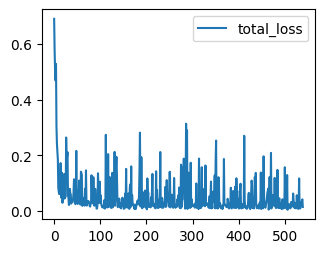

100%|██████████| 96/96 [00:00<00:00, 400.59it/s]


(0.9863013698630136, 0.9260450160771704, 0.9552238805970148, None) [0.40841758]


In [17]:
# Initialize lists to store evaluation metrics across multiple training runs
gied_ap = []   # Average Precision scores
gied_prf = []  # Precision, Recall, F1-score tuples

# Run training and evaluation with 5 different random seeds
for seedi in range(5):
    # Model configuration parameters
    NAME = 'FinalModel_OnlineBoutique'  # Model architecture name
    LOSS = 'cross_entropy'              # Loss function
    POOLING = 'attention'               # Graph pooling method
    
    # Initialize and configure the model
    model = callSpatioDevNet(name = NAME, input_dim = INPUT_DIM, hidden_dim = HIDDEN_DIM, 
                           edge_attr_len = EDGE_ATTR_LEN, global_fea_len = GLOBAL_FEA_LEN, 
                           num_epochs = 60, nonlinear_scorer = False, act = False, 
                           pooling = POOLING, loss_func = LOSS, lr = 1e-3, seed = seedi)
    
    # Train the model on training data
    # log_step=10: Print training progress every 10 epochs
    # valid_proportion=0.0: Use all training data (no validation split)
    model.fit(trainlist, log_step = 10, valid_proportion = 0.0)
    
    # Generate predictions on training and test data
    preds, feas = model.predict(trainlist)      # Training predictions
    test_preds, test_feas = model.predict(testlist)  # Test predictions
    
    # Find optimal threshold using training data
    m, m_t = bf_search(train_labels, preds)
    
    # Apply optimal threshold to test predictions and calculate metrics
    gied_prf.append(precision_recall_fscore_support(test_labels, (test_preds > m_t).astype('int'), average = 'binary'))
    gied_ap.append(average_precision_score(test_labels, test_preds))

## Step 18: Display Training Results

Show the detailed performance metrics from the full training evaluation.

In [18]:
# Display precision, recall, F1-score results for all training runs
# Each tuple contains (precision, recall, f1_score, support)
gied_prf

[(0.9898305084745763, 0.926984126984127, 0.9573770491803278, None),
 (0.9930795847750865, 0.9111111111111111, 0.9503311258278145, None),
 (0.9896907216494846, 0.9142857142857143, 0.9504950495049506, None),
 (0.9930795847750865, 0.9111111111111111, 0.9503311258278145, None),
 (0.9930555555555556, 0.9079365079365079, 0.9485903814262022, None)]

## Step 19: Calculate Average Precision

Compute the mean precision across all training runs for overall performance assessment.

In [19]:
# Calculate mean precision across all runs
# Precision = True Positives / (True Positives + False Positives)
np.mean([item[0] for item in gied_prf])

0.9917471910459579

## Step 20: Calculate Average Recall

Compute the mean recall across all training runs for overall performance assessment.

In [20]:
# Calculate mean recall across all runs
# Recall = True Positives / (True Positives + False Negatives)
np.mean([item[1] for item in gied_prf])

0.9142857142857143

## Step 21: Calculate Average F1-Score

Compute the mean F1-score across all training runs for overall performance assessment.

In [21]:
# Calculate mean F1-score across all runs
# F1-score = 2 * (Precision * Recall) / (Precision + Recall)
np.mean([item[2] for item in gied_prf])

0.951424946353422

## Step 22: Display Average Precision Scores

Show the average precision scores from all training runs.

In [22]:
# Display average precision scores for all training runs
# Average precision summarizes the precision-recall curve
gied_ap

[0.9779512147563546,
 0.9778330250090081,
 0.97582772743604,
 0.9764976813700555,
 0.9768707988217223]

## Step 23: Calculate Overall Average Precision

Compute the mean average precision across all training runs for final performance summary.

In [23]:
# Calculate mean average precision across all runs
# This provides a single metric summarizing overall model performance
np.mean(gied_ap)

0.9769960894786361